# Jeelab mouse body tracking example using U-Net

written by 한효빈, HioBeen Han - hiobeen.han@kaist.ac.kr

JEELAB, KIST

version 2021-04-03a

Visit here: https://colab.research.google.com/drive/1UWqUtZdTbFKBWgcSD9x-LhjfTF9nUOW-?usp=sharing


# Part 1. 환경 설정 & 데이터 불러오기

In [1]:
""" SET ENVIRONMENT """
# Drive mount
from google.colab import auth,drive,files
drive.mount('/content/gdrive')

""" Load modules """
import os, cv2
import numpy as np
from glob import glob
from matplotlib import pyplot as plt; from matplotlib import cm; plt.style.use('ggplot')
# Download U-net
!pip install git+https://github.com/karolzak/keras-unet
from keras_unet.models import custom_unet

Mounted at /content/gdrive
  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-f1bk3r61
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-f1bk3r61
  Created wheel for keras-unet: filename=keras_unet-0.1.2-cp37-none-any.whl size=16992 sha256=5fababfae4ceea970f38f08de8905ecaa2a730a742f19c8c2d23559848a6bb2c
  Stored in directory: /tmp/pip-ephem-wheel-cache-6fwpnftv/wheels/b3/3a/85/c3df1c96b5d83dcd2c09b634e72a98cafcf12a52501ac5cd77
Successfully built keras-unet
-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [2]:
""" Google Drive 경로 파일에 되었는지 확인하기 """
# 시스템(리눅스) 명령어 사용은 커맨드 앞에 느낌표(!)를 붙이고 작성
# ls -> listdir의 약자로, directory 내 파일들을 listing 하는 기능을 수행함
# 
!ls gdrive/MyDrive/'Colab Notebooks'/tutorial_data/

frames.zip  trainset_added.zip	trainset.zip


In [3]:
""" 구글드라이브에 올라간 데이터를 Colab 가상환경으로 복사하기 """
# cp 명령어는 copy의 약자로, cp A B라고 쓰면 A를 B 경로로 복사함.
# cp -r A B 라고 쓰면, A라는 디렉토리 내 파일들을 통째로 B에 복사함.
# 이 예시에서는 tutorial_data/ 폴더 내의 파일들을 content/ 안으로 옮길 것. 
#
!cp -r gdrive/MyDrive/'Colab Notebooks'/tutorial_data/ content/

In [4]:
""" Zip 파일들 압축 해제하기 """
!unzip content/trainset.zip -d content/
!unzip content/frames.zip -d content/

Archive:  content/trainset.zip
  inflating: content/data/trainset/.DS_Store  
  inflating: content/data/trainset/frame-000007-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000024-sample_02-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000035-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000038-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000042-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000056-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000069-sample_01-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000083-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000084-sample_03-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-000089-sample_04-from1024x1024-to448x448.jpg  
  inflating: content/data/trainset/frame-0

In [5]:
""" 이미지 데이터를 Numpy array로 읽어오기 """
data_dir = 'content/data/trainset/'
filename_x = glob( data_dir+'frame*.jpg' ); filename_x.sort()
filename_y = glob( data_dir+'mask*.jpg' ); filename_y.sort()

n_files = len( filename_x )
shape = (448, 448)
x_raw = np.zeros(shape=(n_files,shape[0],shape[1]), dtype='float32')
y_raw = np.zeros(shape=(n_files,shape[0],shape[1]), dtype='bool')
for fileIdx in range(n_files):
  x_raw[fileIdx,] = cv2.imread( filename_x[fileIdx] )[:,:,0]
  y_raw[fileIdx,] = cv2.imread( filename_y[fileIdx] )[:,:,0]>0

In [6]:
"""  Dataset augmentation """
# 
# 이미지를 가로/세로/가로세로 반전시켜서 4배르 뻥튀기하기
# 
x_aug = np.zeros( (x_raw.shape[0]*4, x_raw.shape[1], x_raw.shape[2] ), dtype='float32')
y_aug = np.zeros( (y_raw.shape[0]*4, y_raw.shape[1], y_raw.shape[2] ), dtype='bool')

imgIdx = 0
for fileIdx in range(x_raw.shape[0]):
  frame, mask = x_raw[fileIdx,], y_raw[fileIdx,]
  frame = frame/255
  
  # Appending original data
  x_aug[imgIdx,:,:] = frame
  y_aug[imgIdx,:,:] = mask
  imgIdx+=1

  # Flip x-axis 
  x_aug[imgIdx,:,:] = frame[::-1,:]
  y_aug[imgIdx,:,:] = mask[::-1,:]
  imgIdx+=1

  # Flip y-axis 
  x_aug[imgIdx,:,:] = frame[:,::-1]
  y_aug[imgIdx,:,:] = mask[:,::-1]
  imgIdx+=1

  # Flip x & y-axis
  x_aug[imgIdx,:,:] = frame[::-1,::-1]
  y_aug[imgIdx,:,:] = mask[::-1,::-1]
  imgIdx+=1

print(x_aug.shape)


(400, 448, 448)


img idx = 182


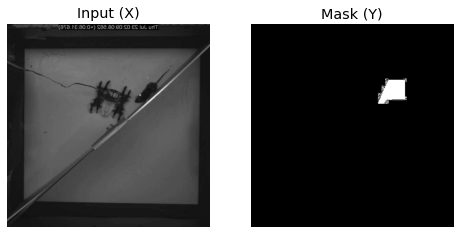

img idx = 239


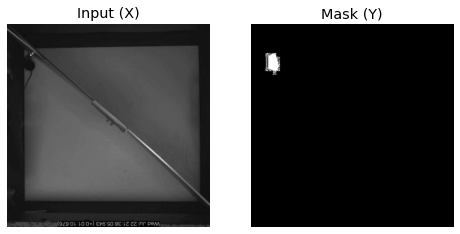

img idx = 306


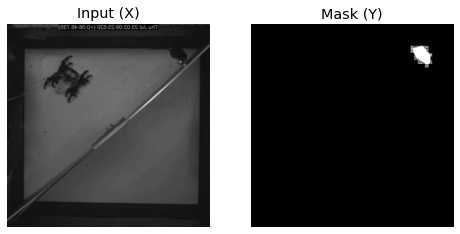

In [7]:
""" 잘 import 되었는지 확인하기 위한 visualization """
plt.style.use('ggplot')
np.random.seed(20210404)
for fIdx in np.random.randint(0,x_aug.shape[0],3):
  print('Image number %s'%fIdx )
  plt.figure(figsize=(8,4))
  plt.subplot(121); plt.imshow(x_aug[fIdx,:,:],  cmap=cm.gray); plt.axis('off')
  plt.title('Input (X)')
  plt.subplot(122); plt.imshow(y_aug[fIdx,:,:], cmap=cm.gray); plt.axis('off')
  plt.title('Mask (Y)')
  plt.show()

#Part 2. CNN 모델 빌드 & 훈련 진행하기


세부적인 파라미터 튜닝 필요


1.   use_batch_norm => 각 레이어의 입/출력을 0-1 사이로 표준화.
2.   filters => 필터 사이즈 (클수록 sparse하게 봄).
3.   dropout => 랜덤하게 끊을 커넥션의 비율 (0-1).
4.   output_activation => 활성 함수의 종류 (*relu*, *sigmoid*, *tanh*, etc.).
5.   optimizer => *adam*으로 learning_rate = 1e-04 정도면 적당히 빨리 배움 



In [8]:
""" Train/Test 세트 나누기 """
randseed = 20210404
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    np.expand_dims( x_aug, 3 ), np.expand_dims( y_aug, 3 ),
    test_size=0.1, random_state=np.random.seed(randseed))

print('Training set size => (%d,%d,%d,%d)'%x_train.shape)
print('   Test set size => (%d,%d,%d,%d)'%x_test.shape)

Training set size => (360,448,448,1)
   Test set size => (40,448,448,1)


In [9]:
""" CNN 네트워크 빌드하기 """
from keras.callbacks import History; 
history = History(); histories = []
from keras import backend as K; import gc
gc.collect(); K.clear_session()
from keras import optimizers

model = custom_unet(input_shape=(shape[0],shape[1],1),
    use_batch_norm=1, num_classes=y_train.shape[-1],
    filters=16, dropout=0.20, output_activation='sigmoid')
metric = 'binary_crossentropy'
model.compile(optimizer = 'Adam', loss = metric, metrics = [metric])
#model.summary()

12/12 - 43s - loss: 0.7374 - binary_crossentropy: 0.7374 - val_loss: 0.6141 - val_binary_crossentropy: 0.6141
Epoch => [~  1] / 100


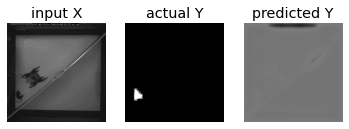

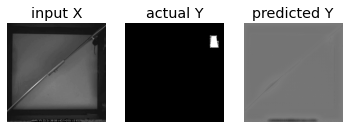

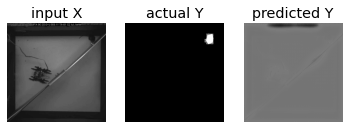

12/12 - 6s - loss: 0.6564 - binary_crossentropy: 0.6564 - val_loss: 0.3968 - val_binary_crossentropy: 0.3968
12/12 - 6s - loss: 0.6179 - binary_crossentropy: 0.6179 - val_loss: 0.4370 - val_binary_crossentropy: 0.4370
12/12 - 6s - loss: 0.5834 - binary_crossentropy: 0.5834 - val_loss: 0.4926 - val_binary_crossentropy: 0.4926
12/12 - 6s - loss: 0.5477 - binary_crossentropy: 0.5477 - val_loss: 0.4957 - val_binary_crossentropy: 0.4957
12/12 - 6s - loss: 0.5095 - binary_crossentropy: 0.5095 - val_loss: 1.3305 - val_binary_crossentropy: 1.3305
12/12 - 6s - loss: 0.4682 - binary_crossentropy: 0.4682 - val_loss: 0.3847 - val_binary_crossentropy: 0.3847
12/12 - 6s - loss: 0.4213 - binary_crossentropy: 0.4213 - val_loss: 0.7654 - val_binary_crossentropy: 0.7654
12/12 - 6s - loss: 0.3729 - binary_crossentropy: 0.3729 - val_loss: 0.2787 - val_binary_crossentropy: 0.2787
12/12 - 6s - loss: 0.3347 - binary_crossentropy: 0.3347 - val_loss: 0.7169 - val_binary_crossentropy: 0.7169
12/12 - 6s - loss: 

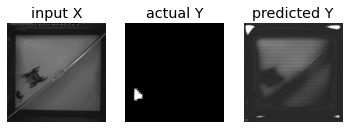

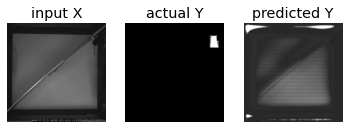

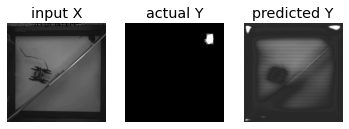

12/12 - 6s - loss: 0.2703 - binary_crossentropy: 0.2703 - val_loss: 0.1813 - val_binary_crossentropy: 0.1813
12/12 - 6s - loss: 0.2422 - binary_crossentropy: 0.2422 - val_loss: 0.1555 - val_binary_crossentropy: 0.1555
12/12 - 6s - loss: 0.2183 - binary_crossentropy: 0.2183 - val_loss: 0.1343 - val_binary_crossentropy: 0.1343
12/12 - 6s - loss: 0.1976 - binary_crossentropy: 0.1976 - val_loss: 0.1250 - val_binary_crossentropy: 0.1250
12/12 - 6s - loss: 0.1786 - binary_crossentropy: 0.1786 - val_loss: 0.1164 - val_binary_crossentropy: 0.1164
12/12 - 6s - loss: 0.1608 - binary_crossentropy: 0.1608 - val_loss: 0.1065 - val_binary_crossentropy: 0.1065
12/12 - 6s - loss: 0.1459 - binary_crossentropy: 0.1459 - val_loss: 0.1003 - val_binary_crossentropy: 0.1003
12/12 - 6s - loss: 0.1328 - binary_crossentropy: 0.1328 - val_loss: 0.0941 - val_binary_crossentropy: 0.0941
12/12 - 6s - loss: 0.1207 - binary_crossentropy: 0.1207 - val_loss: 0.0890 - val_binary_crossentropy: 0.0890
12/12 - 6s - loss: 

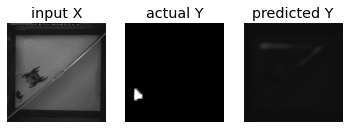

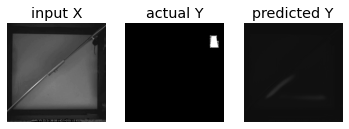

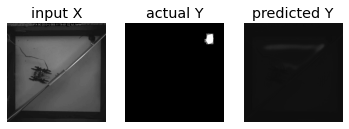

12/12 - 6s - loss: 0.1023 - binary_crossentropy: 0.1023 - val_loss: 0.0797 - val_binary_crossentropy: 0.0797
12/12 - 6s - loss: 0.0933 - binary_crossentropy: 0.0933 - val_loss: 0.0759 - val_binary_crossentropy: 0.0759
12/12 - 6s - loss: 0.0845 - binary_crossentropy: 0.0845 - val_loss: 0.0719 - val_binary_crossentropy: 0.0719
12/12 - 6s - loss: 0.0775 - binary_crossentropy: 0.0775 - val_loss: 0.0654 - val_binary_crossentropy: 0.0654
12/12 - 6s - loss: 0.0715 - binary_crossentropy: 0.0715 - val_loss: 0.0627 - val_binary_crossentropy: 0.0627
12/12 - 6s - loss: 0.0663 - binary_crossentropy: 0.0663 - val_loss: 0.0583 - val_binary_crossentropy: 0.0583
12/12 - 6s - loss: 0.0616 - binary_crossentropy: 0.0616 - val_loss: 0.0623 - val_binary_crossentropy: 0.0623
12/12 - 6s - loss: 0.0571 - binary_crossentropy: 0.0571 - val_loss: 0.0571 - val_binary_crossentropy: 0.0571
12/12 - 6s - loss: 0.0531 - binary_crossentropy: 0.0531 - val_loss: 0.0475 - val_binary_crossentropy: 0.0475
12/12 - 6s - loss: 

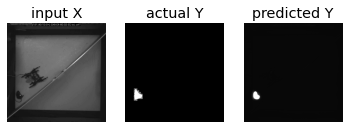

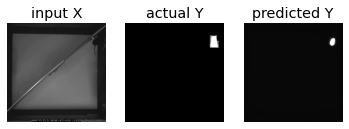

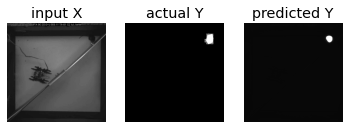

12/12 - 6s - loss: 0.0469 - binary_crossentropy: 0.0469 - val_loss: 0.0424 - val_binary_crossentropy: 0.0424
12/12 - 6s - loss: 0.0438 - binary_crossentropy: 0.0438 - val_loss: 0.0411 - val_binary_crossentropy: 0.0411
12/12 - 6s - loss: 0.0411 - binary_crossentropy: 0.0411 - val_loss: 0.0386 - val_binary_crossentropy: 0.0386
12/12 - 6s - loss: 0.0388 - binary_crossentropy: 0.0388 - val_loss: 0.0358 - val_binary_crossentropy: 0.0358
12/12 - 6s - loss: 0.0368 - binary_crossentropy: 0.0368 - val_loss: 0.0337 - val_binary_crossentropy: 0.0337
12/12 - 6s - loss: 0.0348 - binary_crossentropy: 0.0348 - val_loss: 0.0328 - val_binary_crossentropy: 0.0328
12/12 - 6s - loss: 0.0330 - binary_crossentropy: 0.0330 - val_loss: 0.0318 - val_binary_crossentropy: 0.0318
12/12 - 6s - loss: 0.0312 - binary_crossentropy: 0.0312 - val_loss: 0.0310 - val_binary_crossentropy: 0.0310
12/12 - 6s - loss: 0.0297 - binary_crossentropy: 0.0297 - val_loss: 0.0295 - val_binary_crossentropy: 0.0295
12/12 - 6s - loss: 

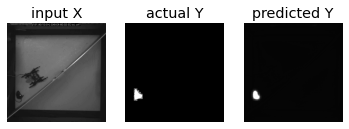

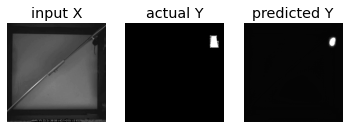

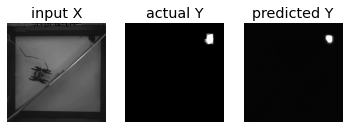

12/12 - 6s - loss: 0.0271 - binary_crossentropy: 0.0271 - val_loss: 0.0281 - val_binary_crossentropy: 0.0281
12/12 - 6s - loss: 0.0259 - binary_crossentropy: 0.0259 - val_loss: 0.0264 - val_binary_crossentropy: 0.0264
12/12 - 6s - loss: 0.0249 - binary_crossentropy: 0.0249 - val_loss: 0.0270 - val_binary_crossentropy: 0.0270
12/12 - 6s - loss: 0.0238 - binary_crossentropy: 0.0238 - val_loss: 0.0248 - val_binary_crossentropy: 0.0248
12/12 - 6s - loss: 0.0229 - binary_crossentropy: 0.0229 - val_loss: 0.0238 - val_binary_crossentropy: 0.0238
12/12 - 6s - loss: 0.0219 - binary_crossentropy: 0.0219 - val_loss: 0.0233 - val_binary_crossentropy: 0.0233
12/12 - 6s - loss: 0.0212 - binary_crossentropy: 0.0212 - val_loss: 0.0233 - val_binary_crossentropy: 0.0233
12/12 - 6s - loss: 0.0205 - binary_crossentropy: 0.0205 - val_loss: 0.0219 - val_binary_crossentropy: 0.0219
12/12 - 6s - loss: 0.0197 - binary_crossentropy: 0.0197 - val_loss: 0.0202 - val_binary_crossentropy: 0.0202
12/12 - 6s - loss: 

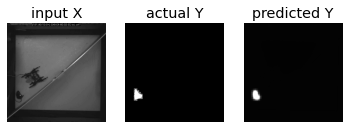

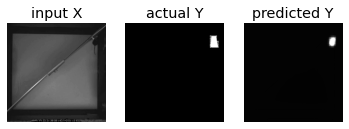

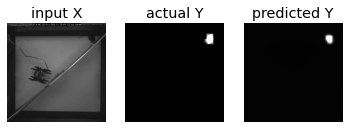

12/12 - 6s - loss: 0.0182 - binary_crossentropy: 0.0182 - val_loss: 0.0207 - val_binary_crossentropy: 0.0207
12/12 - 6s - loss: 0.0178 - binary_crossentropy: 0.0178 - val_loss: 0.0209 - val_binary_crossentropy: 0.0209
12/12 - 6s - loss: 0.0173 - binary_crossentropy: 0.0173 - val_loss: 0.0194 - val_binary_crossentropy: 0.0194
12/12 - 6s - loss: 0.0166 - binary_crossentropy: 0.0166 - val_loss: 0.0189 - val_binary_crossentropy: 0.0189
12/12 - 6s - loss: 0.0161 - binary_crossentropy: 0.0161 - val_loss: 0.0195 - val_binary_crossentropy: 0.0195
12/12 - 6s - loss: 0.0156 - binary_crossentropy: 0.0156 - val_loss: 0.0186 - val_binary_crossentropy: 0.0186
12/12 - 6s - loss: 0.0153 - binary_crossentropy: 0.0153 - val_loss: 0.0175 - val_binary_crossentropy: 0.0175
12/12 - 6s - loss: 0.0149 - binary_crossentropy: 0.0149 - val_loss: 0.0162 - val_binary_crossentropy: 0.0162
12/12 - 6s - loss: 0.0149 - binary_crossentropy: 0.0149 - val_loss: 0.0157 - val_binary_crossentropy: 0.0157
12/12 - 6s - loss: 

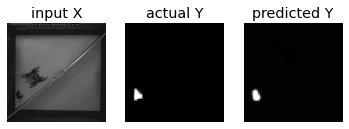

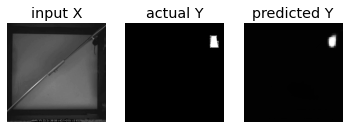

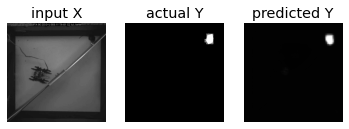

12/12 - 6s - loss: 0.0144 - binary_crossentropy: 0.0144 - val_loss: 0.0177 - val_binary_crossentropy: 0.0177
12/12 - 6s - loss: 0.0140 - binary_crossentropy: 0.0140 - val_loss: 0.0153 - val_binary_crossentropy: 0.0153
12/12 - 6s - loss: 0.0135 - binary_crossentropy: 0.0135 - val_loss: 0.0150 - val_binary_crossentropy: 0.0150
12/12 - 6s - loss: 0.0129 - binary_crossentropy: 0.0129 - val_loss: 0.0162 - val_binary_crossentropy: 0.0162
12/12 - 6s - loss: 0.0126 - binary_crossentropy: 0.0126 - val_loss: 0.0155 - val_binary_crossentropy: 0.0155
12/12 - 6s - loss: 0.0122 - binary_crossentropy: 0.0122 - val_loss: 0.0156 - val_binary_crossentropy: 0.0156
12/12 - 6s - loss: 0.0120 - binary_crossentropy: 0.0120 - val_loss: 0.0159 - val_binary_crossentropy: 0.0159
12/12 - 6s - loss: 0.0118 - binary_crossentropy: 0.0118 - val_loss: 0.0149 - val_binary_crossentropy: 0.0149
12/12 - 6s - loss: 0.0114 - binary_crossentropy: 0.0114 - val_loss: 0.0148 - val_binary_crossentropy: 0.0148
12/12 - 6s - loss: 

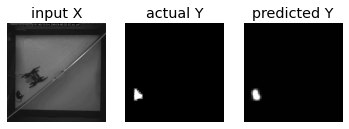

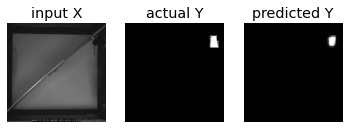

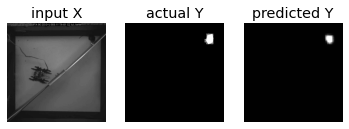

12/12 - 6s - loss: 0.0109 - binary_crossentropy: 0.0109 - val_loss: 0.0155 - val_binary_crossentropy: 0.0155
12/12 - 6s - loss: 0.0107 - binary_crossentropy: 0.0107 - val_loss: 0.0145 - val_binary_crossentropy: 0.0145
12/12 - 6s - loss: 0.0105 - binary_crossentropy: 0.0105 - val_loss: 0.0149 - val_binary_crossentropy: 0.0149
12/12 - 6s - loss: 0.0103 - binary_crossentropy: 0.0103 - val_loss: 0.0151 - val_binary_crossentropy: 0.0151
12/12 - 6s - loss: 0.0101 - binary_crossentropy: 0.0101 - val_loss: 0.0138 - val_binary_crossentropy: 0.0138
12/12 - 6s - loss: 0.0099 - binary_crossentropy: 0.0099 - val_loss: 0.0143 - val_binary_crossentropy: 0.0143
12/12 - 6s - loss: 0.0098 - binary_crossentropy: 0.0098 - val_loss: 0.0157 - val_binary_crossentropy: 0.0157
12/12 - 6s - loss: 0.0097 - binary_crossentropy: 0.0097 - val_loss: 0.0145 - val_binary_crossentropy: 0.0145
12/12 - 6s - loss: 0.0094 - binary_crossentropy: 0.0094 - val_loss: 0.0157 - val_binary_crossentropy: 0.0157
12/12 - 6s - loss: 

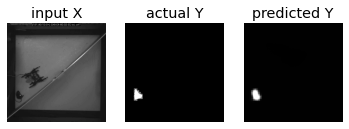

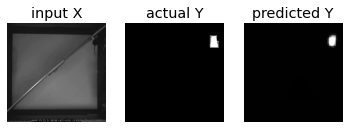

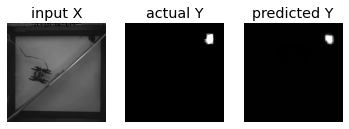

12/12 - 6s - loss: 0.0091 - binary_crossentropy: 0.0091 - val_loss: 0.0143 - val_binary_crossentropy: 0.0143
12/12 - 6s - loss: 0.0089 - binary_crossentropy: 0.0089 - val_loss: 0.0159 - val_binary_crossentropy: 0.0159
12/12 - 6s - loss: 0.0088 - binary_crossentropy: 0.0088 - val_loss: 0.0148 - val_binary_crossentropy: 0.0148
12/12 - 6s - loss: 0.0086 - binary_crossentropy: 0.0086 - val_loss: 0.0140 - val_binary_crossentropy: 0.0140
12/12 - 6s - loss: 0.0088 - binary_crossentropy: 0.0088 - val_loss: 0.0136 - val_binary_crossentropy: 0.0136
12/12 - 6s - loss: 0.0087 - binary_crossentropy: 0.0087 - val_loss: 0.0116 - val_binary_crossentropy: 0.0116
12/12 - 6s - loss: 0.0084 - binary_crossentropy: 0.0084 - val_loss: 0.0133 - val_binary_crossentropy: 0.0133
12/12 - 6s - loss: 0.0083 - binary_crossentropy: 0.0083 - val_loss: 0.0134 - val_binary_crossentropy: 0.0134
12/12 - 6s - loss: 0.0081 - binary_crossentropy: 0.0081 - val_loss: 0.0150 - val_binary_crossentropy: 0.0150
12/12 - 6s - loss: 

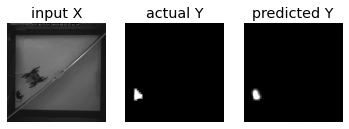

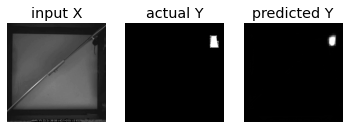

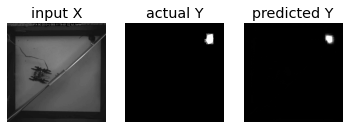

12/12 - 6s - loss: 0.0079 - binary_crossentropy: 0.0079 - val_loss: 0.0145 - val_binary_crossentropy: 0.0145
12/12 - 6s - loss: 0.0078 - binary_crossentropy: 0.0078 - val_loss: 0.0132 - val_binary_crossentropy: 0.0132
12/12 - 6s - loss: 0.0077 - binary_crossentropy: 0.0077 - val_loss: 0.0131 - val_binary_crossentropy: 0.0131
12/12 - 6s - loss: 0.0075 - binary_crossentropy: 0.0075 - val_loss: 0.0150 - val_binary_crossentropy: 0.0150
12/12 - 6s - loss: 0.0074 - binary_crossentropy: 0.0074 - val_loss: 0.0134 - val_binary_crossentropy: 0.0134
12/12 - 6s - loss: 0.0074 - binary_crossentropy: 0.0074 - val_loss: 0.0133 - val_binary_crossentropy: 0.0133
12/12 - 6s - loss: 0.0074 - binary_crossentropy: 0.0074 - val_loss: 0.0118 - val_binary_crossentropy: 0.0118
12/12 - 6s - loss: 0.0072 - binary_crossentropy: 0.0072 - val_loss: 0.0141 - val_binary_crossentropy: 0.0141


In [10]:
""" Training """
fitIdx, nFit = 1, 100
while fitIdx < nFit:
  history = model.fit(x_train,y_train,epochs=1,verbose=2,batch_size=32, validation_data=(x_test,y_test) )
  
  # Sample visualization
  if np.mod(fitIdx,10)==1:
    print('Epoch => [~%3d] / %3d'%((fitIdx), nFit))
    pred = model.predict(x_test)
    for predIdx in range(3):
      plt.figure(figsize=(6,3))
      plt.subplot(1,3,1); plt.imshow(x_test[predIdx,:,:,0], cmap=cm.gray); plt.axis('off'); plt.title('input X')
      plt.subplot(1,3,2); plt.imshow(y_test[predIdx,:,:,0], cmap=cm.gray); plt.axis('off'); plt.title('actual Y')
      plt.subplot(1,3,3); plt.imshow(pred[predIdx,:,:,0], cmap=cm.gray); plt.axis('off'); plt.title('predicted Y')
      plt.clim(0,1); plt.show()
  fitIdx += 1
 

# Part 3. Non-training frames (Full video) 에 대해 모델 prediction 적용하기

In [11]:
""" Video frame 읽어온 후 predict 하기 + 그림 파일로 save 하기 """
from datetime import datetime, timedelta
datestr = (datetime.now()+timedelta(hours=9)).strftime("%Y%m%d-%H%M%S")

dir_import = 'content/data/frames/'
dirList = glob(dir_import+'*sample*')
dirList.sort() 

writedir = 'content/data/predicts/'
#!rm -r content/data/predicts/
os.system('mkdir %s'%writedir);
for dirName in dirList:
  print('Now processing [%s]..'%dirName)
  predicts, frames = [], []

  # set directory
  dir_export = writedir+dirName.split('/')[-1]+'/'
  if not os.path.isdir(dir_export): os.mkdir(dir_export)
  
  # Get files
  fileList = glob(dirName+'/frame*.jpg'); fileList.sort()
  for fileName_load in fileList:
    fileName_save = dir_export+'mask'+fileName_load.split('/')[-1][5:]
    exist = len( glob(fileName_save) )>0

    if True:#if not exist:
      # Load raw frame
      frame = cv2.imread(fileName_load)[:,:,0]/255
      frame = np.swapaxes(np.expand_dims(np.array(frame),2),0,2)
  
      # Predict
      pred = np.squeeze(model.predict(frame))
      #plt.imshow(255*pred); plt.show()
  
      # Save mask
      fileName_save = dir_export+'pred'+fileName_load.split('/')[-1][5:]
      cv2.imwrite(fileName_save,pred*255)

os.system('zip -r content/predicts-%s.zip content/data/predicts/'%datestr)
files.download('content/predicts-%s.zip'%datestr)


Now processing [content/data/frames/sample_01]..
Now processing [content/data/frames/sample_02]..
Now processing [content/data/frames/sample_03]..
Now processing [content/data/frames/sample_04]..


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
""" 저장하기 """
# 모델 파일 저장하기
model_fname = 'content/model-%s.h5'%datestr
model.save_weights(model_fname)

# 구글드라이브에 백업하기
os.system('zip -r content/predicts-%s.zip content/data/predicts/'%datestr)
os.system("cp content/predicts-%s.zip content/gdrive/MyDrive/'Colab Notebooks'/tutorial_data/"%datestr)
os.system("cp content/model-%s.h5 content/gdrive/MyDrive/'Colab Notebooks'/tutorial_data/"%datestr)

# 로컬 컴퓨터에 다운로드 받기
files.download('content/predicts-%s.zip'%datestr)
files.download('content/model-%s.h5'%datestr)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>